# Простейшие нейронные сети с Keras


Фреймворк Keras+Tensorflow сейчас стремительно теряет популярность, но еще совсем недавно многие сетки писались именно на нем, поэтому какое-то базовое знакомство все равно пригодится. Сейчас актуальна версия TF номер 2.

Одна из особенностей новой версии заключается в том, что Keras (раньше он был посторонней библиотекой-надстройкой) фактически [стал частью tensorflow.](https://www.tensorflow.org/guide/keras?hl=ru)  

Изначально Keras создавался как высокоуровневое API для theano (это когда написали кучу функций один раз, красиво их назвали и завернули в пакет). Потом он начал поддерживать tensorflow, а сейчас вот чуть ли ни аннексия произошла. __Keras наш.__ Именно со знакомства с ним мы и начнём наше погружение в нейросетки.  

Чтобы установить библиотеку, отправляйтесь в консоль и пропишите 

```
pip install tensorflow
```

Если вы до этого сидели на старой версии tensorflow, на всякий случай снесите её. Иначе при установке могут возникнуть какие-нибудь несовместимости и ошибки.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Подгружаем tensorflow 
import tensorflow as tf
import tensorflow.keras as keras


print(tf.__version__)


2023-02-09 13:11:33.920765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


In [3]:
# Подгрузим ещё немного пакетов :) 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

## 1. О данных и бейзлайнах

Наша главная цель - как следует потрогать Keras своими руками. Мы хотим увидеть, что он реально позволяет обращаться с нейронками как с конструктором LEGO и предлагает нам для сборки башен кучу деталей. 

__Делать всё это мы будем на животных.__ Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [4]:
X = pd.read_csv('data/X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv('data/y_cat.csv', sep = '\t', index_col=0, names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [5]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставить четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [6]:
target = target.values
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

array([2, 1, 0, ..., 0, 3, 3])

In [8]:
len(y)

26729

In [9]:
X.shape

(26729, 37)

Разобьём выборку на тренировочную и тестовую. 

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


Прежде, чем учить 228-слойных монстров, давайте построим какие-нибудь простые прогнозы, чтобы было с чем сравнить. Давайте построим наивный прогноз, а также обучим линейную регрессию и случайный лес.

### Константный прогноз

Построим константный прогноз, чтобы было с чем сравнивать и прогноз по какой-нибудь модели. 

In [11]:
from sklearn.metrics import log_loss

probas = np.array(pd.Series(y_train).value_counts(normalize=True).sort_index().tolist())
probas

array([0.40289015, 0.0655661 , 0.17906748, 0.35247627])

In [12]:
log_loss(y_test, np.tile(probas, X_test.shape[0]).reshape(X_test.shape[0], 4))

1.2202552496487795

### Логистическая регрессия

In [13]:
from sklearn.linear_model import LogisticRegression

# обучите логистическую регрессию с предсказанием вероятностей (predict_proba)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
log_loss(y_test, logreg.predict_proba(X_test))

1.069057571148371

In [14]:
# выведите предсказания модели на тесте
logreg.predict_proba(X_test)

array([[0.18708845, 0.06705039, 0.04653509, 0.69932606],
       [0.71548998, 0.02923132, 0.10843126, 0.14684744],
       [0.52375562, 0.03809675, 0.18069444, 0.25745319],
       ...,
       [0.77509654, 0.01024853, 0.17602697, 0.03862796],
       [0.22847272, 0.05773861, 0.03826464, 0.67552403],
       [0.66541259, 0.03011851, 0.12082758, 0.18364132]])

### Случайный лес 

In [15]:
from sklearn.ensemble import RandomForestClassifier

# обучите рандомный лес и посчитайте logloss 
rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
rf.fit(X_train, y_train)
log_loss(y_test, rf.predict_proba(X_test))

0.7564762371930179

Попробуем улучшить результат с помощью нейросеток. 

## 2. Собираем свою нейросеть

In [18]:
from tensorflow.keras import layers as L         # Уже готовые слои для моделей
from tensorflow.keras.models import Sequential   # Специальный класс для склеивания слоёв
from tensorflow.keras.models import Model        # Альтернативный класс для склейки слоёв
import tensorflow.keras.optimizers as opt        # Разные оптимизационные алгоритмы :3 

Модель в Keras собирается как конструктор LEGO. Её можно описать двумя основными способами. Первый — последовательное описание модели. В его случае мы как бы создаём коробочку `model` и постепенно добавляем туда детальки нашей сетки. 

Второй способ - описать модель функционально, в явном виде прописав какие аргументы идут на вход какому слою. 

Когда мы будем строить сложные модели с кучей разветвлений, для нас будет удобным второй способ. Для простых ситуаций вроде текущей, можете пользоваться первым. 

Давайте соберём небольшую нейронку. Давайте сделаем в ней вот такую архитектуру: 

In [19]:
from tensorflow.keras.metrics import Accuracy

def get_new_model():
    acc = Accuracy()

    ###########################################################
    model = Sequential(name = 'Archibald')  # модели можно дать имя!
    
    # Добавляем в нашу модель первый слой из 25 нейронов
    model.add(L.Dense(25, input_dim = X_train.shape[1], kernel_initializer='random_normal'))

    # Добавляем функцию активации на первый слой 
    model.add(L.Activation('sigmoid'))

    # Добавляем ещё один слой из 25 нейронов
    model.add(L.Dense(25, kernel_initializer='random_normal'))
    model.add(L.Activation('sigmoid'))

    # На выходе мы должны получить вероятности того, что объект относится к разным классам 
    # Сделать такое преобразование позволяет softmax как функция активации
    # На выход будет идти 4 вероятности по числу классов
    model.add(L.Dense(4, activation='softmax', kernel_initializer = 'random_normal'))
    
    ###########################################################
    
    # В качестве оптимизации будем использовать Adam
    # Это такой специальный градиентный спуск, обсудим его в следущий раз
    optimizer = opt.Adam(lr=1e-3)

    # Собираем модель
    model.compile(loss = 'categorical_crossentropy', 
                  metrics=['acc'], 
                  optimizer=optimizer)
    
    return model

Перед тем как обучать нашу нейросеть, нужно задать параметры обучения. Во-первых, метод оптимизации. Во-вторых, функцию потерь. В-третьих, парочку метрик, на которые нам хотелось бы смотреть в процессе обучения.  Для этого есть метод `compile`. 

In [20]:
model = get_new_model()

Итак, только что мы собрали свою первую нейросеть со скрытым слоем.   Посмотрим сколько параметров нам предстоит оценить. 

In [21]:
model.summary()

Model: "Archibald"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                950       
                                                                 
 activation (Activation)     (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 activation_1 (Activation)   (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 104       
                                                                 
Total params: 1,704
Trainable params: 1,704
Non-trainable params: 0
_________________________________________________________________


Видим, что нужно оценить огромное количество параметров. На оценку каждого параметра придётся совсем маленькое количество наблюдений. 

In [22]:
X_train.shape[0] / 1704

12.548708920187794

Отлично! Модель собрана. Осталось её обучить. Метод `fit` позволяет сделать это. Он принимает на вход обучающую выборку `X_train, y_train`. Параметр  `batch_size` это  размер батча. Этот параметр ограничивает количество примеров, которое за раз подаётся в нашу нейронную сеть. Количиство эпох для обучения, `epochs` - это число проходов модели по обучающей выборке. 

Обычно нейросетки обучаются довольно долго. В связи с этим обучать их на различных фолдах и оценивать качество работы модели на кросс-валидации не очень быстрое занятие, которое себе может позволить далеко не каждый. Для проверки качества обычно внутри обучения с помощью параметра `validation_split` часть выборки оставляют под валидацию, которая осуществляется после каждой эпохи. Как только качество на валидации начнёт падать, это будет означать, что модель переобучилаcь. 

Всё, что будет нам возвращать метод `.fit`, мы запишем в переменную `hist`. После обученя модели там окажется вся история ошибок на каждом шаге обучения. Отключить сообщения о том, на каком этапе обучения в данный момент находится модель, можно с параметром `verbose = 0`. Переменную $y$ для успешного обучения сетки нужно будет перевести в матрицу из дамми-переменных с помощью команды `to_categorical`. 

In [23]:
from tensorflow.keras.utils import to_categorical
to_categorical(y)

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [24]:
hist = model.fit(X_train, to_categorical(y_train), validation_split=0.2, epochs=30, verbose=1, batch_size=128)

Epoch 1/30
134/134 [==============================] - 1s 7ms/step - loss: 1.2427 - acc: 0.3996 - val_loss: 1.2055 - val_acc: 0.3982
Epoch 2/30
134/134 [==============================] - 1s 5ms/step - loss: 1.1944 - acc: 0.4020 - val_loss: 1.1727 - val_acc: 0.3982
Epoch 3/30
134/134 [==============================] - 1s 5ms/step - loss: 1.1590 - acc: 0.4028 - val_loss: 1.1445 - val_acc: 0.3982
Epoch 4/30
134/134 [==============================] - 1s 5ms/step - loss: 1.1426 - acc: 0.4243 - val_loss: 1.1382 - val_acc: 0.4171
Epoch 5/30
134/134 [==============================] - 0s 4ms/step - loss: 1.1393 - acc: 0.4259 - val_loss: 1.1375 - val_acc: 0.4171
Epoch 6/30
134/134 [==============================] - 0s 4ms/step - loss: 1.1380 - acc: 0.4276 - val_loss: 1.1359 - val_acc: 0.4171
Epoch 7/30
134/134 [==============================] - 1s 5ms/step - loss: 1.1394 - acc: 0.4284 - val_loss: 1.1408 - val_acc: 0.4171
Epoch 8/30
134/134 [==============================] - 1s 5ms/step - loss: 1.

In [25]:
preds = tf.argmax(model.predict(X_train), axis=1)

669/669 [==============================] - 2s 2ms/step


In [26]:
preds

<tf.Tensor: shape=(21383,), dtype=int64, numpy=array([3, 0, 0, ..., 3, 0, 0])>

In [27]:
acc = Accuracy()

In [28]:
acc(preds,y_train)

<tf.Tensor: shape=(), dtype=float32, numpy=0.4308563>

Возвращает этот метод history — это история ошибок на каждом шаге обучения. Посмотрим на динамику ошибок нашей модели во времени. 

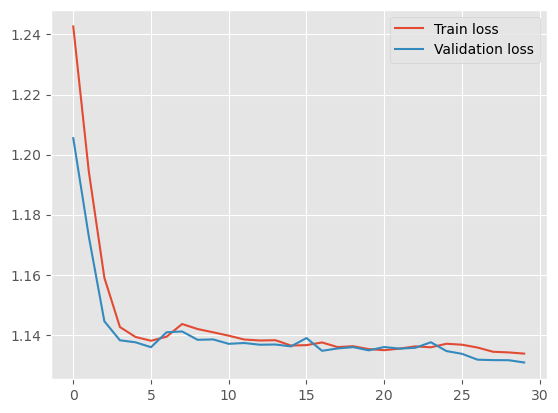

In [31]:
start = 0
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

In [32]:
# Можно предсказать вероятности для тестовой выборки
model.predict(X_test)

168/168 [==============================] - 0s 2ms/step


array([[0.46460775, 0.03833157, 0.01807499, 0.47898567],
       [0.4538054 , 0.05042255, 0.12828071, 0.3674914 ],
       [0.46461424, 0.03833413, 0.01808224, 0.47896945],
       ...,
       [0.45380533, 0.05042256, 0.1282807 , 0.36749136],
       [0.4646054 , 0.03833064, 0.01807231, 0.4789917 ],
       [0.46461967, 0.03833628, 0.01808834, 0.47895575]], dtype=float32)

In [33]:
# А можно классы 
tf.argmax(model.predict(X_train), axis=1)

669/669 [==============================] - 1s 2ms/step


<tf.Tensor: shape=(21383,), dtype=int64, numpy=array([3, 0, 0, ..., 3, 0, 0])>

In [34]:
# Можно найти logloss
log_loss(y_test, model.predict(X_test))

168/168 [==============================] - 0s 3ms/step


1.139080515748055

In [ ]:
# Можно сохранить модель
model.save("weights.h5")

In [35]:
# Можно посмотреть на качество модели по всем указанным при коммпиляции метрикам. 
score = model.evaluate(X_test, to_categorical(y_test), verbose=0)
score

[1.1390804052352905, 0.4276094138622284]

Модель сходится довольно плохо. Функция потерь на валидации со временем начинает скакать. __Как думаете, с чем это связано?__

----------------------------------

__Ответ:__ Вспомним про такую замечательную штуку как нормализация и посмотрим насколько она улучшит скорость обучения и качество модели.

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучаем модель на нормализованных данных. Попробуем учить подольше. Так сказать: двойной удар по сходимости. 

In [37]:
model = get_new_model()  # Эпох стало 300 вместо 100
hist = model.fit(X_train, to_categorical(y_train), validation_split=0.2, epochs=30, verbose=0)

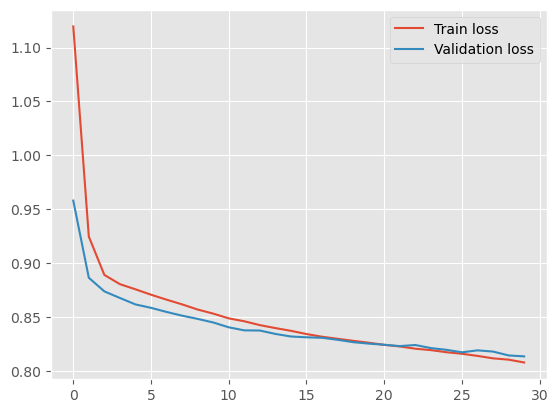

In [38]:
start = 0
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])
plt.show()

In [39]:
score = model.evaluate(X_test, to_categorical(y_test), verbose=0)
score 

[0.8359448909759521, 0.6604938507080078]

Качество нашей модели на валидационных данных достигает пика после определенного количества эпох, а затем начинает снижаться. Это происходит из-за того, что модель начинает __переобучаться.__ Очень важно знать способы как можно предотвратить это. Переобученая модель просто запоминает выборку. Нам бы хотелось, чтобы она обобщала закономерности и адекватно вела себа на новых данных.

Обратным случаем переобучения является __недообучение.__ Оно возникает, когда все еще есть возможность улучшить показатели модели на проверочном наборе данных. Недообучение может произойти по разным причинам: например, если модель недостаточно сильная, или слишком сложная, или просто недостаточно тренировалась на данных. В любом случае это будет означать, что не были выучены основные паттерны из проверочного сета. Нам нужно найти золотую середину.

Чтобы избежать переобучения, наиболее оптимальным решением будет использовать больше тренировочных данных. Модели, обученные на большем количестве данных, естественным образом обобщают их лучше. Если возможность раздобыть ещё данных исчерпана, можно использовать методы регуляризации. Они ограничивают количество и тип инофрмации, которые модель может хранить в себе. Если нейросеть может запомнить только небольшое количество паттернов, то тогда процесс оптимизации заставит ее сфокусироваться на самых важных, наиболее заметных шаблонах, которые будут иметь более высокий шанс обобщения. __Попробуем дать переобучению бой!__

## Различные воспитательные трюки 

1. Начните с маленькой сети. Не забывайте прикидывать сколько наблдюдений $n$ тратится на оценку каждого из $k$ параметров. Если величина $\frac{n}{k}$ очень маленькая, то не может идти речи об адекватных оценках параметров!  
2. Всегда оставляйте часть выборки под валидацию на каждой эпохе.
3. Усложняйте модель, пока качество на валидации не начнёт падать.
4. Не забывайте проскалировать ваши наблюдения для лучшей сходимости. 
5. Можно попробовать ещё целую серию различных **трюков**: 


* __Архитектура нейросети__
    * Больше/меньше нейронов
    * Больше/меньше слоёв 
    * Другие функции активации (tanh, relu, leaky relu, elu etc) 
    * Регуляризация (dropout, l1,l2) 


* __Более качественная оптимизация__  
    * Можно попробовать выбрать другой метод оптимизации 
    * Можно попробовать менять скорость обучения, моментум и др.
    * Разные начальные значения весов


* __Попробовать собрать больше данных__ 
* __Для случая картинок объёмы данных можно увеличить искусственно с помощью подхода, который называется Data augmemntation, но об этом позже__

И это далеко не полный список. Обратите внимание, что делать grid_search для больших сеток это довольно времязатратное занятие... 

## 4. Эксперименты 

Наверняка, у каждого в голове возникла какая-то классная идея по улучшению нашей базовой архитектуры. Пора реализовать её! Если идей нет, попробуйте: 

- Поменять функции активации на elu или сигмоиды
- Увеличить размер архитектуры 

Не забывайте сохранять историю обучения и закидывать её на наш график для сравнения. Когда надоест, посмотрите на итоговое качество модели на тесте. А то по валидации и переобучиться можно :) 

In [ ]:
def get_new_model():
    acc = Accuracy()

    model = Sequential([
        L.Dense(25, input_dim = X_train.shape[1], kernel_initializer='he_normal'),
        L.Dropout(0.2),
        L.Activation(tf.nn.relu),
        L.Dense(25, kernel_initializer='he_normal', activation='ReLU'),
        L.Dense(4, activation='softmax', kernel_initializer='random_normal')

    ], name = 'First')  

    optimizer = opt.Adam(lr=1e-3)

    model.compile(loss = 'categorical_crossentropy', 
                  metrics=['acc'], 
                  optimizer=optimizer)
    
    return model

In [ ]:
model = get_new_model()

In [ ]:
hist = model.fit(X_train, to_categorical(y_train), validation_split=0.2, epochs=30, verbose=1, batch_size=128)

In [ ]:
score = model.evaluate(X_test, to_categorical(y_test), verbose=0)
score 

In [ ]:
start = 0
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])